In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np



In [2]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S2/PRL/241114/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S2/PRL/250120/data'

In [3]:
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None


In [4]:
def extract_data_from_single_file(file_path):
    try:
        # Try reading with different encodings
        df = pd.read_csv(file_path, sep='\s+', header=None, names=['x', 'y'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [5]:
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [6]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)


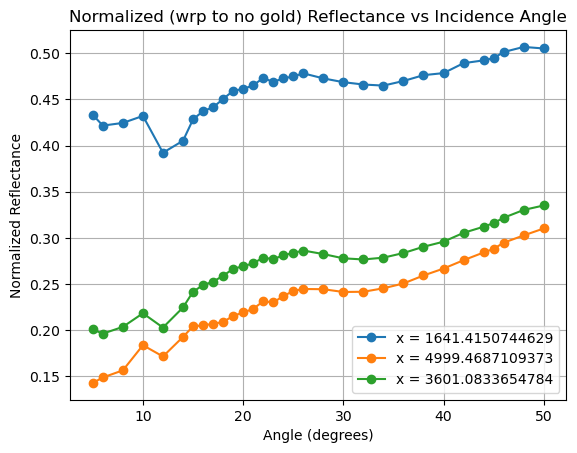

In [7]:
# Function to plot y2/y1 vs angle for a specific x value with lines between dots
def plot_y2_y1_ratio_vs_angle(x_value, data_y1, data_y2, label=None):
    angles = []
    ratios = []

    # Iterate through all angles in data_y1 (which should match those in data_y2)
    for angle in data_y1:
        # Check if the angle exists in both y1 and y2 data
        if angle in data_y2:
            # Extract y1 and y2 values for the given x_value
            y1_value = data_y1[angle][data_y1[angle]['x'] == x_value]['y']
            y2_value = data_y2[angle][data_y2[angle]['x'] == x_value]['y']

            if not y1_value.empty and not y2_value.empty:
                # Calculate the ratio y2/y1
                ratio = y2_value.iloc[0] / y1_value.iloc[0]
                angles.append(angle)
                ratios.append(ratio)

    # Sort the angles and corresponding ratios in ascending order of angle
    sorted_angles, sorted_ratios = zip(*sorted(zip(angles, ratios)))

    # Plot the ratio y2/y1 vs angle with dots and lines between them
    plt.plot(sorted_angles, sorted_ratios, marker='o', linestyle='-', label=label)  # Use lines and dots
    plt.title(f'Normalized (wrp to no gold) Reflectance vs Incidence Angle')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Normalized Reflectance')
    plt.grid(True)

# Example usage: Plot for a specific x value
x_value1 = 1641.4150744629
x_value2 = 4999.4687109373
x_value3 = 3601.0833654784

plot_y2_y1_ratio_vs_angle(x_value1, data_y1, data_y2, label=f'x = {x_value1}')
plot_y2_y1_ratio_vs_angle(x_value2, data_y1, data_y2, label=f'x = {x_value2}')
plot_y2_y1_ratio_vs_angle(x_value3, data_y1, data_y2, label=f'x = {x_value3}')

plt.legend()
plt.show()


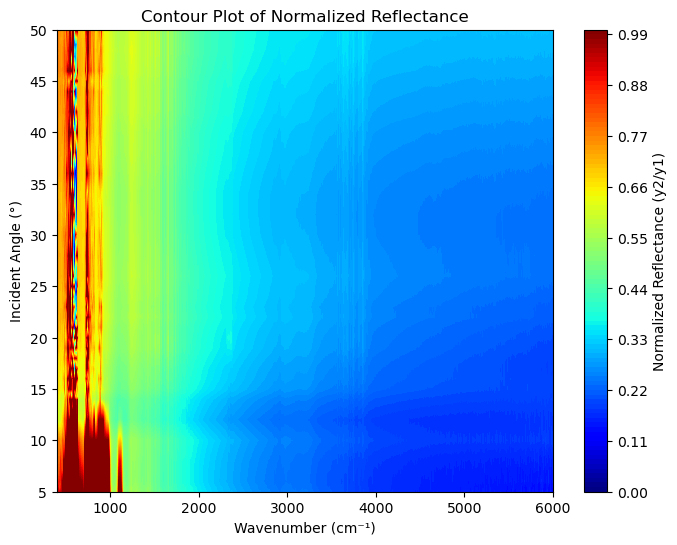

In [8]:
#Extract sorted list of angles
angles = sorted(data_y1.keys())
x_values = data_y1[angles[0]]["x"].values  # Assuming all x-values are the same across angles

# Initialize a 2D array for the reflectance ratio
R = np.zeros((len(angles), len(x_values)))

# Compute y2/y1 for each angle efficiently
for i, angle in enumerate(angles):
    y1_values = data_y1[angle]["y"].values
    y2_values = data_y2[angle]["y"].values
    R[i, :] = y2_values / y1_values  # Element-wise division

# Clip values to ensure they are in the range [0, 1]
R = np.clip(R, 0, 1)

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(x_values, angles, R, levels=100, cmap="jet", vmin=0, vmax=1)

# Labels and colorbar
plt.colorbar(label="Normalized Reflectance (y2/y1)")
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Incident Angle (°)")
plt.title("Contour Plot of Normalized Reflectance")

# Show the plot
plt.show()


dip of reflectance at theta = 12

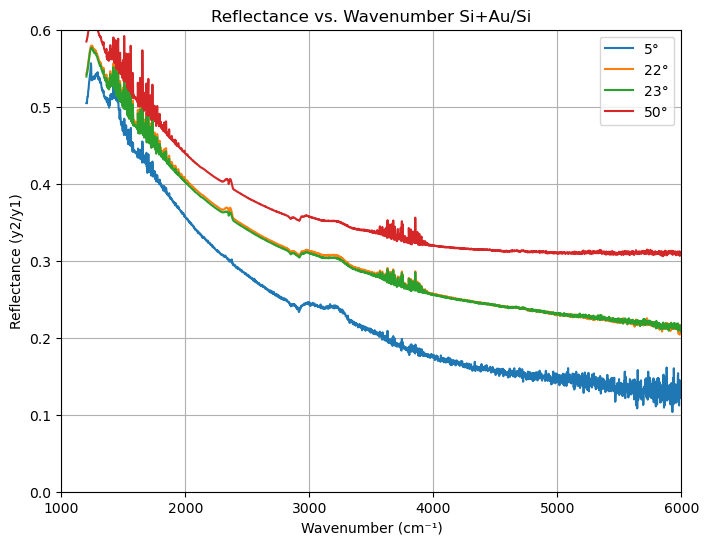

In [11]:
# Define the specific angles you want to plot
chosen_angles = [5, 22, 23, 50]  # Modify this list to plot only specific angles

plt.figure(figsize=(8, 6))

for angle in chosen_angles:
    if angle in data_y1 and angle in data_y2:  # Ensure angle exists in both dictionaries
        df1 = data_y1[angle]
        df2 = data_y2[angle]
        
        # Filter wavenumbers greater than 1200 cm^-1
        mask = df1["x"].values > 1200
        wavenumbers = df1["x"].values[mask]
        reflectance = (df2["y"].values / df1["y"].values)[mask]  # Compute y2/y1
        
        plt.plot(wavenumbers, reflectance, label=f"{angle}°")  # Plot with label

plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("Reflectance (y2/y1)")
plt.title("Reflectance vs. Wavenumber Si+Au/Si")
plt.xlim(1000, 6000)
plt.ylim(0, 0.6)
plt.legend()
plt.grid(True)

plt.show()


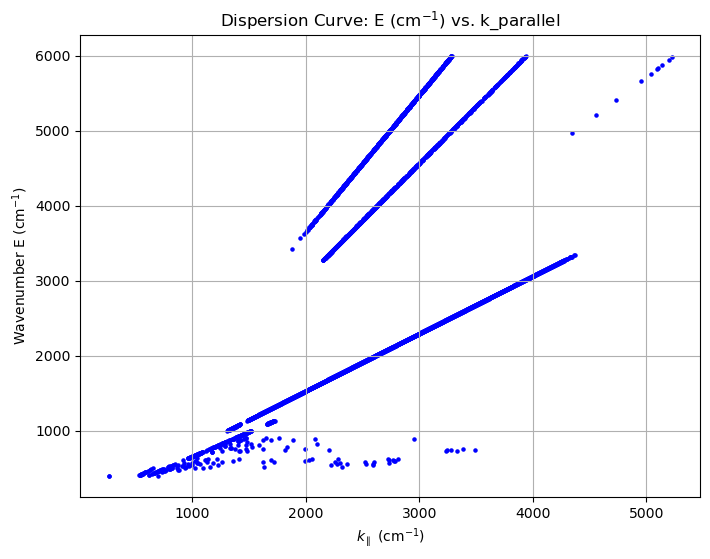

In [9]:
# Extract sorted list of angles and wavenumbers
angles = np.array(sorted(data_y1.keys()))
x_values = data_y1[angles[0]]["x"].values  # Assuming all x-values are the same across angles

# Initialize arrays to store min angles
sin_theta_min = np.zeros(len(x_values))

# Compute normalized reflectance y2/y1 and find min angles
for j, x in enumerate(x_values):
    reflectivity = np.array([data_y2[angle]["y"].values[j] / data_y1[angle]["y"].values[j] for angle in angles])
    min_angle = angles[np.argmin(reflectivity)]  # Find the angle corresponding to the minimum reflectance
    sin_theta_min[j] = np.sin(np.radians(min_angle))  # Convert to radians and take sin

# Plot Dispersion Curve (E vs k_parallel)
k_parallel = (2 * np.pi * x_values) * sin_theta_min  # k_parallel = (2pi/lambda) * sin(theta)

plt.figure(figsize=(8, 6))
plt.scatter(k_parallel, x_values, marker="o",s=5, linestyle="-", color="b")  # x_values corresponds to Energy (E)
plt.xlabel(r"$k_{\parallel}$ (cm$^{-1}$)")
plt.ylabel("Wavenumber E (cm$^{-1}$)")
plt.title("Dispersion Curve: E (cm$^{-1}$) vs. k_parallel")
plt.grid(True)

plt.show()
